In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Lets begin by importing our bit coin price data.

chosen_col variable can be changed here to alter what recorded price to use.

In [ ]:
import matplotlib.pyplot as plt

data = '../input/cryptocurrencypricehistory/coin_Bitcoin.csv'
dataset = pd.read_csv(data)
chosen_col = 'Close'

And then taking a look at the first few columns. 

In [ ]:
print(len(dataset))
dataset.head()

Splitting our data into what will be our training set VS the test set so we can visualize it.

In [ ]:
split_row = len(dataset) - int(0.2 * len(dataset))
train_data = dataset.iloc[:split_row]
test_data = dataset.iloc[split_row:]

In [ ]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(train_data[chosen_col], label='Train', linewidth=2)
ax.plot(test_data[chosen_col], label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

We can see that there are some pretty wild fluctuations at the end, lets leave this as it is for the time being and see what happens.

Continue by normalizing the values to floats between 0-1. We are using sklearn's MinMaxScaler. We need to be careful to fit the scaler on our entire data range or else we will end up with a messed up scale between our test data and our train data. After we fit it we then transform both our test and training data.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

datacol = dataset.iloc[:, 7:8].values
traincol = train_data.iloc[:, 7:8].values
testcol = test_data.iloc[:, 7:8].values

shaped_data = np.reshape(datacol, (-1,1))
train_shaped = np.reshape(traincol, (-1,1))
test_shaped = np.reshape(testcol, (-1,1))

sc = MinMaxScaler(feature_range=(0,1))
sc.fit(shaped_data)

train_scaled_data = sc.transform(train_shaped)
test_scaled_data = sc.transform(test_shaped)

Now we seperate our training data into our inputs and our outputs in time steps of time_steps. Where we will look at time_steps amount of data before we make our prediction of what the output for y will be.

In [ ]:
X = []
y = []
time_steps = 50

for i in range(time_steps, len(train_data)):
    X.append(train_scaled_data[i-time_steps:i,0])
    y.append(train_scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

Splitting our training data into training and validation.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Now we implement our actual model. We start with an LSTM input layer with 100 hidden units. We add a dropout of 0.2 before our Dense output layer with a linear activation and a shape of 1 (as we are outputting our expected price). We are using mean squared error to calculate our loss and adam as our optimizer.

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation

model = Sequential()
model.add(LSTM(units=100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(optimizer='adam', loss='mse')

Fit our model now on our X and y training/validation data. We take advantage of keras' early stopping class so that once we are no longer recieving improvements the model will take its best weights and stop.

In [ ]:
from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=1, callbacks=[callback], shuffle=True)

In [ ]:
model.summary()

Now we are breaking our testing data up into time steps and splitting it again into our inputs and our expected outputs. 

We then predict on the inputs and then scale both the inputs and outputs back up, now were ready to see how we did!

In [ ]:
from keras.metrics import mean_absolute_error

X_testing = []
y_testing = []

for i in range(time_steps, len(test_data)):
    X_testing.append(test_scaled_data[i-time_steps:i,0])
    y_testing.append(test_scaled_data[i, 0])

X_testing, y_testing = np.array(X_testing), np.array(y_testing)
X_testing = np.reshape(X_testing, (X_testing.shape[0], X_testing.shape[1], 1))

predicted_price = model.predict(X_testing)
inv_price = sc.inverse_transform(predicted_price)
real_price = np.reshape(y_testing, (-1,1))
real_price = sc.inverse_transform(real_price)

In [ ]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(real_price, label='Real', linewidth=2)
ax.plot(inv_price, label='Pred', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

It looks ok! Considering this was a very large spike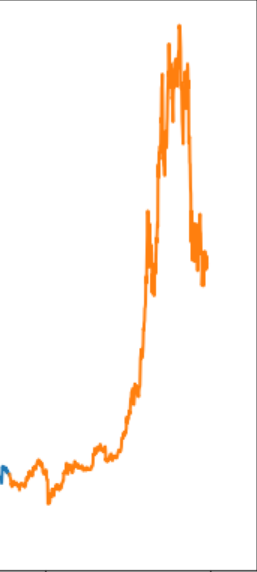

The orange in the orignal graph is the testing data we are using here so you can see that the price spiked from 10k USD all the way to 60k and back down to 35k.

The largest problem I see with the predictions is that on the larger changes it lags a bit behind the actual prices, while far from an expert, I assume this comes from the model still being innacurate when it comes to such violent volatility like was shown in the data.